In [1]:
# load pretrained model
import torch
# load an image from local file
from PIL import Image
from torchvision import transforms
import torchvision
import time
import pandas as pd
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
model.eval()
with open('classes.txt') as f:
  labels = [line.strip() for line in f.readlines()]

Using cache found in C:\Users\dell/.cache\torch\hub\pytorch_vision_v0.6.0


## Define transformation

In [2]:
# define transformations
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Load Dataset

In [3]:
testset = torchvision.datasets.ImageNet(root='./data', split='val',
                                       transform=transformations)
dataloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

## Test Model on Labeled Dataset

In [12]:
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# image_data = torchvision.datasets.ImageFolder(
#     "./testimages",
#     transform=transformations
# )
# dataloader = torch.utils.data.DataLoader(
#     dataset=image_data,
#     batch_size=32,
#     shuffle=False,
#     num_workers=8
# )

def cal_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

counter = 0
# Tell torch not to calculate gradients
model = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)
model.eval()
device = torch.device('cpu')
# device = torch.device("cuda")
# model.cuda()
batch_size = 32
with torch.no_grad():
    val_loss = 0
    accuracy_1 = 0
    accuracy_5 = 0
    counter = 0
    testLen = 10
    timeConsume = 0
    iters = [i for i in range(10, 201, 10)]
    top_1s = []
    top_5s = []
    times = []
    idx = 0
    for inputs, labels in dataloader:
        if idx == len(iters):
            break
        if counter == iters[idx]:
            top_1s.append(accuracy_1/counter)
            top_5s.append(accuracy_5/counter)
            times.append(timeConsume)
            idx += 1
            print("top_1s: ", top_1s)
            print('top_5s: ', top_5s)
            print('times: ', times)
        # Move to device
        inputs, labels = inputs.to(device), labels.to(device)
        # Forward pass
        start = time.time()
        output = model.forward(inputs)
#         # Calculate Loss
#         valloss = criterion(output, labels)
#         # Add loss to the validation set's running loss
#         val_loss += valloss.item()*inputs.size(0)

        # Since our model outputs a LogSoftmax, find the real 
        # percentages by reversing the log function
        output = torch.exp(output)
        # Get the top class of the output
        top_p, top_class = output.topk(1, dim=1)
        res = cal_accuracy(output, labels.view(batch_size), (1,5))
        top_1 = res[0].item()
        top_5 = res[1].item()
        end = time.time()
        timeConsume += (end - start)
#         # See how many of the classes were correct?
#         equals = top_class == labels.view(*top_class.shape)
#         # Calculate the mean (get the accuracy for this batch)
#         # and add it to the running accuracy for this epoch
#         accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        accuracy_1 += top_1
        accuracy_5 += top_5

        # Print the progress of our evaluation
        counter += 1
        print(counter, "/", 200)

    # Get the average loss for the entire epoch
    # valid_loss = val_loss/len(dataloader.dataset)
    # Print out the information
    print('top_1: {}, top_5:{}'.format(accuracy_1/testLen, accuracy_5/testLen))
    print('consumed time: {}'.format(timeConsume))
    # print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
    df = pd.DataFrame(iters, columns=['iters'])
    df2 = pd.DataFrame(top_1s, columns=['top_1'])
    df3 = pd.DataFrame(top_5s, columns=['top_5'])
    df4 = pd.DataFrame(times, columns=['consumeTime'])
    result = pd.concat([df, df2, df3, df4], axis=1)
    result.to_csv('result2.csv', encoding='utf-8', index=True)

Using cache found in C:\Users\dell/.cache\torch\hub\pytorch_vision_v0.6.0


1 / 200
2 / 200
3 / 200
4 / 200
5 / 200
6 / 200
7 / 200
8 / 200
9 / 200
10 / 200
top_1s:  [80.9375]
top_5s:  [95.0]
times:  [14.110009670257568]
11 / 200
12 / 200
13 / 200
14 / 200
15 / 200
16 / 200
17 / 200
18 / 200
19 / 200
20 / 200
top_1s:  [80.9375, 83.125]
top_5s:  [95.0, 95.3125]
times:  [14.110009670257568, 27.78084945678711]
21 / 200
22 / 200
23 / 200
24 / 200
25 / 200
26 / 200
27 / 200
28 / 200
29 / 200
30 / 200
top_1s:  [80.9375, 83.125, 84.79166666666667]
top_5s:  [95.0, 95.3125, 95.72916666666667]
times:  [14.110009670257568, 27.78084945678711, 41.591941356658936]
31 / 200
32 / 200
33 / 200
34 / 200
35 / 200
36 / 200
37 / 200
38 / 200
39 / 200
40 / 200
top_1s:  [80.9375, 83.125, 84.79166666666667, 85.9375]
top_5s:  [95.0, 95.3125, 95.72916666666667, 96.015625]
times:  [14.110009670257568, 27.78084945678711, 41.591941356658936, 55.674476623535156]
41 / 200
42 / 200
43 / 200
44 / 200
45 / 200
46 / 200
47 / 200
48 / 200
49 / 200
50 / 200
top_1s:  [80.9375, 83.125, 84.791666666

171 / 200
172 / 200
173 / 200
174 / 200
175 / 200
176 / 200
177 / 200
178 / 200
179 / 200
180 / 200
top_1s:  [80.9375, 83.125, 84.79166666666667, 85.9375, 85.125, 81.61458333333333, 80.49107142857143, 79.21875, 78.50694444444444, 76.96875, 76.05113636363636, 76.09375, 76.39423076923077, 77.32142857142857, 78.35416666666667, 78.65234375, 78.80514705882354, 78.85416666666667]
top_5s:  [95.0, 95.3125, 95.72916666666667, 96.015625, 95.5625, 94.84375, 94.41964285714286, 93.90625, 93.78472222222223, 93.28125, 92.8125, 93.02083333333333, 92.90865384615384, 93.19196428571429, 93.41666666666667, 93.53515625, 93.47426470588235, 93.45486111111111]
times:  [14.110009670257568, 27.78084945678711, 41.591941356658936, 55.674476623535156, 69.56447577476501, 83.24447202682495, 98.41869044303894, 112.38818168640137, 125.94670248031616, 139.3677203655243, 152.6877245903015, 165.9595730304718, 179.28260850906372, 192.7106213569641, 205.93973970413208, 219.2977409362793, 232.55974650382996, 245.70975494384

## Plot accuracy

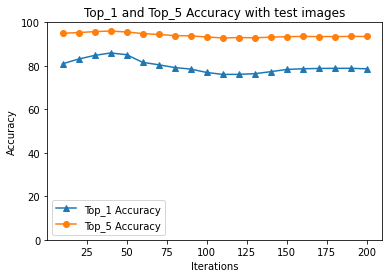

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(iters, top_1s, label='Top_1 Accuracy', marker='^')
ax.plot(iters, top_5s, label='Top_5 Accuracy', marker='o')
ax.set_ylim(0, 100)
ax.set_xlabel('Iterations')
ax.set_ylabel('Accuracy')
ax.set_title('Top_1 and Top_5 Accuracy with test images')
ax.legend()



## Plot time

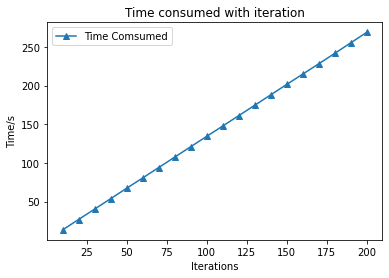

In [70]:
fig, bx = plt.subplots()
bx.plot(iters, times, label='Time Comsumed', marker='^')

bx.set_xlabel('Iterations')
bx.set_ylabel('Time/s')
bx.set_title('Time consumed with iteration')
bx.legend()

## Plot comparison time, skip the previous one

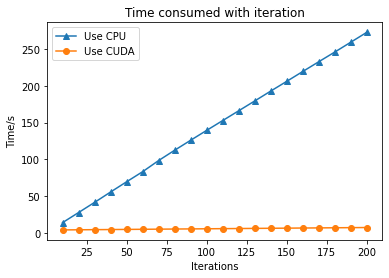

In [17]:
ori = pd.read_csv('result.csv')['consumeTime'].tolist()
fig, bx = plt.subplots()
bx.plot(iters, times, label='Use CPU', marker='^')
bx.plot(iters, ori, label='Use CUDA', marker='o')
bx.set_xlabel('Iterations')
bx.set_ylabel('Time/s')
bx.set_title('Time consumed with iteration')
bx.legend()


## Inference using TensonRT

In [11]:
import tensorrt as trt
import numpy as np
import pycuda.autoinit
import pycuda.driver as cuda 
import time
import keras
from keras.preprocessing.image import ImageDataGenerator
ONNX_FILE_PATH = 'mobilenetv2-7.onnx'
input_size = 32

TRT_LOGGER = trt.Logger(trt.Logger.WARNING)

def build_engine(model_path):
    with trt.Builder(TRT_LOGGER) as builder, \
        builder.create_network() as network, \
        trt.OnnxParser(network, TRT_LOGGER) as parser: 
        builder.max_workspace_size = 1<<20
        builder.max_batch_size = 1
        with open(model_path, "rb") as f:
            parser.parse(f.read())
        engine = builder.build_cuda_engine(network)
        return engine

def alloc_buf(engine):
    # host cpu mem
    h_in_size = trt.volume(engine.get_binding_shape(0))
    h_out_size = trt.volume(engine.get_binding_shape(1))
    h_in_dtype = trt.nptype(engine.get_binding_dtype(0))
    h_out_dtype = trt.nptype(engine.get_binding_dtype(1))
    in_cpu = cuda.pagelocked_empty(h_in_size, h_in_dtype)
    out_cpu = cuda.pagelocked_empty(h_out_size, h_out_dtype)
    # allocate gpu mem
    in_gpu = cuda.mem_alloc(in_cpu.nbytes)
    out_gpu = cuda.mem_alloc(out_cpu.nbytes)
    stream = cuda.Stream()
    return in_cpu, out_cpu, in_gpu, out_gpu, stream


def inference(engine, context, inputs, out_cpu, in_gpu, out_gpu, stream):
    # async version
    # with engine.create_execution_context() as context:  # cost time to initialize
    # cuda.memcpy_htod_async(in_gpu, inputs, stream)
    # context.execute_async(1, [int(in_gpu), int(out_gpu)], stream.handle, None)
    # cuda.memcpy_dtoh_async(out_cpu, out_gpu, stream)
    # stream.synchronize()

    # sync version
    cuda.memcpy_htod(in_gpu, inputs)
    context.execute(1, [int(in_gpu), int(out_gpu)])
    cuda.memcpy_dtoh(out_cpu, out_gpu)
    return out_cpu

inputs = np.random.random((1, 3, input_size, input_size)).astype(np.float32)
engine = build_engine(ONNX_FILE_PATH)
context = engine.create_execution_context()
iters = [i*32 for i in range(10, 201, 10)]
idx = 0
times = []
consumeT = 0
for i in range(6401):
    t1 = time.time()
    in_cpu, out_cpu, in_gpu, out_gpu, stream = alloc_buf(engine)
    res = inference(engine, context, inputs.reshape(-1), out_cpu, in_gpu, out_gpu, stream)
    if i == iters[idx]:
        consume = time.time()-t1
        consumeT = consumeT + consume
        times.append(consumeT)
        print("consumed time: {}".format(consumeT))
        idx += 1
print(times)

consumed time: 0.0008525848388671875
consumed time: 0.001699209213256836
consumed time: 0.0026171207427978516
consumed time: 0.003473997116088867
consumed time: 0.0043222904205322266
consumed time: 0.00538945198059082
consumed time: 0.0062944889068603516
consumed time: 0.007220745086669922
consumed time: 0.00812840461730957
consumed time: 0.008996725082397461
consumed time: 0.009845256805419922
consumed time: 0.010943889617919922
consumed time: 0.011803627014160156
consumed time: 0.012718439102172852
consumed time: 0.013638973236083984
consumed time: 0.014492511749267578
consumed time: 0.01537942886352539
consumed time: 0.01627373695373535
consumed time: 0.017133235931396484
consumed time: 0.017983198165893555
[0.0008525848388671875, 0.001699209213256836, 0.0026171207427978516, 0.003473997116088867, 0.0043222904205322266, 0.00538945198059082, 0.0062944889068603516, 0.007220745086669922, 0.00812840461730957, 0.008996725082397461, 0.009845256805419922, 0.010943889617919922, 0.01180362701

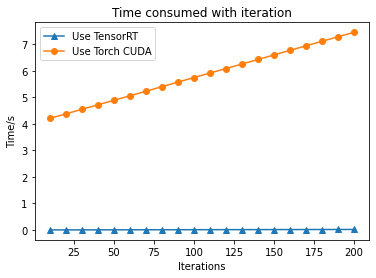

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
iters = [i for i in range(10, 201, 10)]
ori = pd.read_csv('result.csv')['consumeTime'].tolist()
fig, bx = plt.subplots()
bx.plot(iters, times, label='Use TensorRT', marker='^')
bx.plot(iters, ori, label='Use Torch CUDA', marker='o')
bx.set_xlabel('Iterations')
bx.set_ylabel('Time/s')
bx.set_title('Time consumed with iteration')
bx.legend()

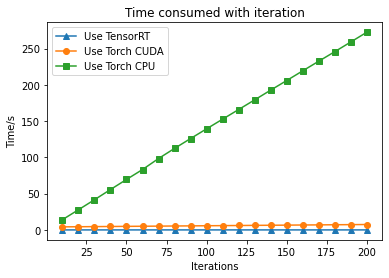

In [13]:
cpu = pd.read_csv('result2.csv')['consumeTime'].tolist()
fig, bx = plt.subplots()
bx.plot(iters, times, label='Use TensorRT', marker='^')
bx.plot(iters, ori, label='Use Torch CUDA', marker='o')
bx.plot(iters, cpu, label="Use Torch CPU", marker='s')
bx.set_xlabel('Iterations')
bx.set_ylabel('Time/s')
bx.set_title('Time consumed with iteration')
bx.legend()